In [19]:
import numpy
import time
import tensorflow as tf
from matplotlib import pyplot as plt

In [20]:
omega = 1.0
hbar  = 1.0
M     = 1

# This is a granularity parameter:
delta = 0.0005

In [21]:
class ExponentialBoundaryCondition(tf.keras.layers.Layer):
    
    def __init__(self, exp=1.0, trainable=True):
        tf.keras.layers.Layer.__init__(self)

        # This is the parameter controlling the shape of the exponent:
        self.exponent = tf.Variable(exp, trainable=trainable, dtype=tf.float32)


    def call(self, inputs):

        return tf.exp(- (self.exponent * inputs) **2 / 2.)

In [22]:
class NeuralWavefunction(tf.keras.layers.Layer):
    
    def __init__(self):
        tf.keras.layers.Layer.__init__(self)
        
        self.layer1 = tf.keras.layers.Dense(32)
        self.layer2 = tf.keras.layers.Dense(32)
        self.layer3 = tf.keras.layers.Dense(1)
    
        self.norm   = 1.0
        
        # This is an exponent for normalization:
        self.exp = ExponentialBoundaryCondition()


    def call(self, inputs):
        x = inputs
        x = self.layer1(x)
        x = tf.nn.tanh(x)
        x = self.layer2(x)
        x = tf.nn.tanh(x)
        x = self.layer3(x)

        boundary_condition = self.exp(inputs)

        output = self.norm*x*boundary_condition
        return output

    
    def update_normalization(self, inputs):
        # Inputs is expected to be a range of parameters along an x axis.
        value = self.call(inputs)
        N = value ** 2

        delta = inputs[1]-inputs[0]

        N = tf.reduce_sum(N) * delta
        self.norm *= 1/tf.sqrt(N)

        # The normalization condition is that the integral of the wavefunction squared
        # should be equal to 1 (probability sums to 1.)

        return
    


In [23]:
# This is preparing input data that is differentiable:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = tf.Variable(_x, trainable = True)

In [24]:
w_nn = NeuralWavefunction()
w_nn.update_normalization(x)

y_nn = w_nn(x)

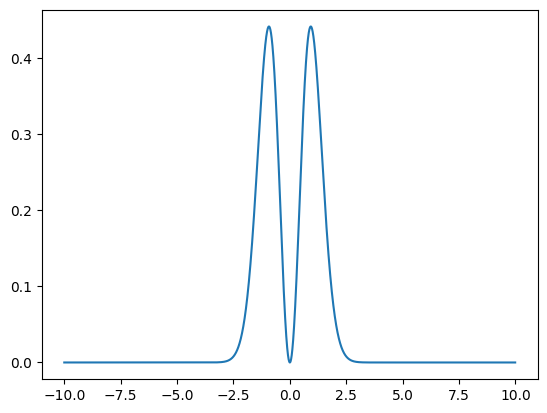

In [7]:
plt.plot(x.numpy(), (y_nn**2).numpy(), label="N.N.")

In [8]:
tape = tf.GradientTape(persistent=True)

In [9]:
def potential_energy(wavefunction, inputs, delta):
    temp = 0.5*(M * omega **2) * wavefunction(inputs)**2 * inputs**2
    return tf.reduce_sum(temp) * delta

In [10]:
def kinetic_energy(wavefunction, inputs, delta):
    tape = tf.GradientTape()
    with tape:
        y = wavefunction(inputs)
    wavefunction_prime = tape.gradient(y, inputs)
    return (hbar**2 / (2 *M)) * tf.reduce_sum(wavefunction_prime**2) * delta

In [11]:
def normalization(wavefunction, inputs, delta):
    psi = wavefunction(inputs)**2
    return tf.reduce_sum(psi*delta)

In [12]:
def energy_calculation(wavefunction, inputs, delta):
    norm = normalization(wavefunction, inputs, delta)
    pe = potential_energy(wavefunction, inputs, delta)
    ke = kinetic_energy(wavefunction, inputs, delta)
    energy = (1/norm) * ( pe +  ke)
    return energy

In [13]:
print("Energy of w_nn: ", energy_calculation(w_nn, x, delta))

Energy of w_nn:  tf.Tensor(1.5126228, shape=(), dtype=float32)


In [14]:
# optimized function - for SSYM
#def energy_computation(boson, fermion, inputs, delta):
#    diff(FERMION)[x]
#    return BOSON_NI + BOSON_I + FERMION_NI + FERMION_I

def energy_computation(boson_wf, inputs, delta):
    # This function takes the inputs (assumed to be a range of real value parameters)
    # And computes the expectation value of the energy.
    
    # create a gradient tape:
    tape = tf.GradientTape()
    
    # This is the value of the wave function:
    with tape:
        w_of_x = boson_wf(inputs)
    
    # This is the first derivative of the wave function:
    w_prime_dx = tape.gradient(w_of_x, inputs)
    
    # Now we can compute integrals:
    normalization = tf.reduce_sum(w_of_x**2) * delta
    
    pe = (0.5 * M * omega**2 ) * (w_of_x**2) * (inputs**2)    
    ke = (hbar**2 / (2 *M)) * (w_prime_dx**2)

    ke = tf.reduce_sum(ke) * delta
    pe = tf.reduce_sum(pe) * delta

    energy = (pe + ke) / normalization
    
    return energy

In [15]:
def generate_input(delta):
    # Create fresh input data:
    _x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
    _x = _x.reshape((_x.shape[0], 1))

    x = tf.Variable(_x, trainable = True)

    return x
    
def training_step(wavefunction, optimizer, delta):
    # Clear all gradients from the optimizer:
    exterior_tape = tf.GradientTape()
    
    x = generate_input(delta)

    wavefunction.update_normalization(x)
    
    # Compute the energy:
    with exterior_tape:
        energy = energy_computation(wavefunction, x, delta)

    # We back-prop'd through the wave function once already in the energy computation.  Clear the gradients:
    
    gradients = exterior_tape.gradient(energy, wavefunction.trainable_variables)

    optimizer.apply_gradients(zip(gradients, wavefunction.trainable_variables))
    
    # Lastly, update the normaliztion 
    wavefunction.update_normalization(x)

    return  energy


In [16]:
w_nn = NeuralWavefunction()
delta = 0.0001

x = generate_input(delta)
y = w_nn(x)

optimizer = tf.keras.optimizers.Adam()

energy_history = []
step_history = []

for i in range(100):
    start = time.time()
    energy = training_step(w_nn, optimizer, delta)
    end = time.time()
    if i % 10 == 0: print(f"Energy :{energy.numpy()}, {end - start:.2}s per step")
    
    
    energy_history.append(energy.numpy())
    step_history.append(i)

Energy :1.5449750423431396, 0.87s per step
Energy :0.5870647430419922, 0.7s per step
Energy :0.5288552641868591, 0.71s per step
Energy :0.5115994811058044, 0.66s per step
Energy :0.5053171515464783, 0.69s per step
Energy :0.5047810673713684, 0.69s per step
Energy :0.5035996437072754, 0.69s per step
Energy :0.5025681853294373, 0.67s per step
Energy :0.5019236207008362, 0.68s per step
Energy :0.5014618039131165, 0.67s per step


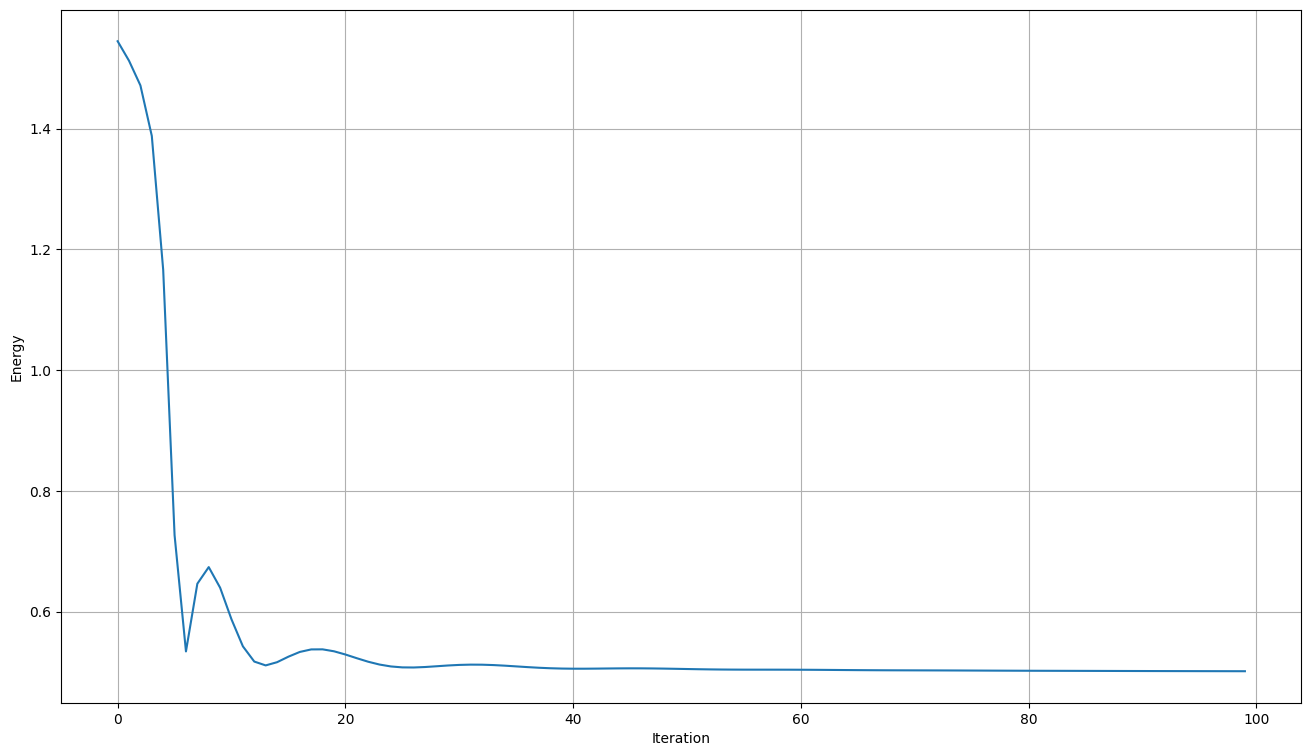

In [17]:
fig = plt.figure(figsize=(16,9))

plt.plot(step_history, energy_history)
plt.grid(True)
plt.ylabel("Energy")
plt.xlabel("Iteration")
plt.show()

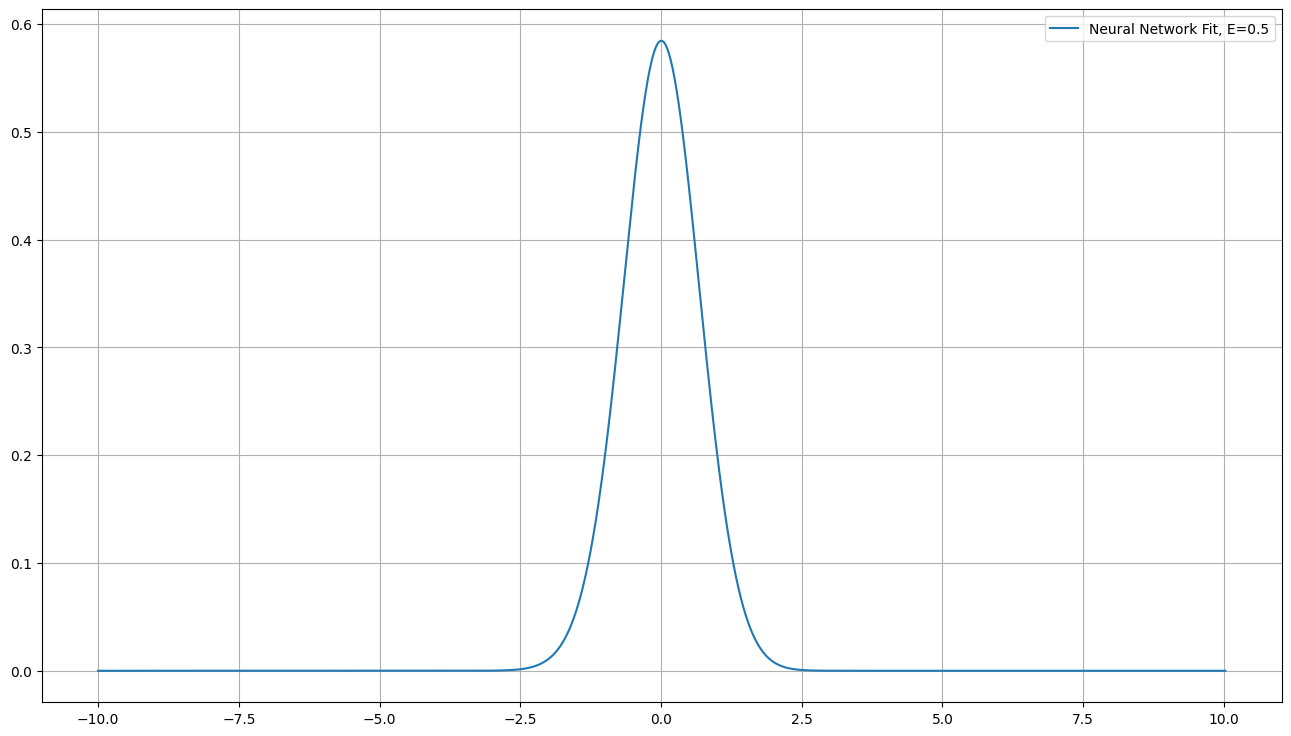

In [18]:
# Create fresh input data:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = tf.Variable(_x, trainable = True)

p_fit   = w_nn(x)**2

x_numpy = x.numpy()

fig = plt.figure(figsize=(16,9))

plt.plot(x_numpy, p_fit.numpy(), label=f"Neural Network Fit, E={energy:.2}")
plt.grid(True)
plt.legend()
plt.show()